In [4]:
import numpy as np
import pandas as pd
from copy import copy
import sys
sys.path.append('/home/ndsviriden/MinMax94/src/utils') 
from constants import data_directory, MmxColumns
from interpolation import interpolate_mmx, create_patterns
from converters import convert_raw_to_mmx
from preprocessing import get_clean_data
from loaders import load_mm94_stations, select_mm94_features
from geographical import find_nearest_wmo_station, add_solar_angles, add_coordinates, add_road_id
from sklearn.ensemble import IsolationForest
from score import get_labels
from score import calculate_precision, calculate_recall
import gc
from tqdm import tqdm_notebook
from functools import reduce

## Loading data

In [5]:
%%time
test_station_id = [114, 117, 119, 302, 303, 307, 393, 442, 503, 504, 
                   511, 516, 1838, 1896]


train_station_id = [113, 115, 116, 118, 126, 150, 152, 200, 223, 228, 
                    239, 305, 308, 309, 401, 411, 432, 435, 454, 456, 
                    593, 628, 1831, 1899, 1911, 1921, 4007, 20323, 20717, 20743, 
                    20754, 20755, 20761, 20916, 20921]

raw = load_mm94_stations(train_station_id + test_station_id)
raw = select_mm94_features(raw, ['t_air', 't_road', 't_underroad', 'pressure', 'dampness'])

mmx_rwis = convert_raw_to_mmx(raw)
mmx_rwis_interpolated = interpolate_mmx(mmx_rwis)
data = create_patterns(mmx_rwis_interpolated)

data['data_solar_azimuth'], data['data_solar_altitude'] = add_solar_angles(data)
data['data_latitude'], data['data_longitude'] = add_coordinates(data)
data['data_road'] = add_road_id(data)
data = data.dropna(subset=('data_t_road', ))

del data[MmxColumns.ID_AIR_TEMPERATURE], data[MmxColumns.ID_UNDERGROUND_TEMPERATURE], \
    data[MmxColumns.ID_PRESSURE], data[MmxColumns.ID_HUMIDITY]

train = data[data['station_id'].isin(train_station_id)]
train = train.reset_index(drop=True)
train_clean = get_clean_data(train)

test = data[data['station_id'].isin(test_station_id)]
test = test.reset_index(drop=True)
test['label_true'] = get_labels(test, labels_type='true')

del data, raw, mmx_rwis, mmx_rwis_interpolated
gc.collect()

/home/ndsviriden/MinMax94/src/utils/geographical.py:65: RuntimeWarning: invalid value encountered in arccos
  solar_azimuth = np.arccos(cos_az) * np.sign(h_rad)


CPU times: user 1min 37s, sys: 10.3 s, total: 1min 47s
Wall time: 1min 51s


## Feature selection

In [25]:
%%time
from preprocessing import create_feature_df

point = pd.Timestamp(2015, 6, 1)

time = 0.5
variables = ['data_t_road', 'data_t_air', 'data_t_underroad', 'data_dampness', 'data_pressure']
road_id = False
coordinates = False

df_train = create_feature_df(train_clean[train_clean['date_time_utc'] < point], winter_period=False, 
                             time=time, variables=variables, road_id=road_id, coordinates=coordinates)
df_valid = create_feature_df(train_clean[train_clean['date_time_utc'] >= point], winter_period=False, 
                             time=time, variables=variables, road_id=road_id, coordinates=coordinates)
df_test = create_feature_df(test, winter_period=False, time=time,
                           variables=variables, road_id=road_id, coordinates=coordinates)

features = [col for col in df_train if col.startswith('data_')]
target = [col for col in df_train if col.startswith('target_')][0]

X_train = np.array(df_train[features].values)
y_train = np.array(df_train[target].values)

X_valid = np.array(df_valid[features].values)
y_valid = np.array(df_valid[target].values)

X_test = np.array(df_test[features].values)
y_test = np.array(df_test[target].values)

CPU times: user 8.66 s, sys: 1.73 s, total: 10.4 s
Wall time: 10.4 s


In [26]:
from sklearn.preprocessing import Normalizer

normalizer = Normalizer()
X_train_norm = normalizer.fit_transform(X_train)
X_valid_norm = normalizer.transform(X_valid)
X_test_norm = normalizer.transform(X_test)

In [33]:
from keras.layers import Input, Dense, BatchNormalization, Dropout
from keras.models import Model
import keras.metrics as metrics
from keras.optimizers import Nadam, Adam

# This returns a tensor
input_layer = Input(shape=(X_train_norm.shape[1],))
#batch_norm = BatchNormalization()(input_layer)
dense_1 = Dense(64, activation='relu')(input_layer)
dropout_1 = Dropout(0.3)(dense_1)
output_layer = Dense(1, activation='linear')(dropout_1)

adam = Adam(lr=0.02)
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='mean_absolute_error',
              optimizer=adam, )

In [34]:
import keras.backend as K

epochs = 10
for epoch in range(epochs):
    model.fit(X_train_norm, y_train, epochs=1, validation_data=(X_valid_norm, y_valid), 
             batch_size=64)  # starts training
    K.set_value(adam.lr, 0.8 * K.get_value(adam.lr))

Train on 1262353 samples, validate on 472539 samples
Epoch 1/1
1262353/1262353 [==============================] - 25s 20us/step - loss: 2.3646 - val_loss: 1.9754
Train on 1262353 samples, validate on 472539 samples
Epoch 1/1
1262353/1262353 [==============================] - 25s 20us/step - loss: 2.2238 - val_loss: 1.9024
Train on 1262353 samples, validate on 472539 samples
Epoch 1/1
1262353/1262353 [==============================] - 25s 20us/step - loss: 2.1999 - val_loss: 1.8376
Train on 1262353 samples, validate on 472539 samples
Epoch 1/1
1262353/1262353 [==============================] - 25s 20us/step - loss: 2.1839 - val_loss: 1.9807
Train on 1262353 samples, validate on 472539 samples
Epoch 1/1
1262353/1262353 [==============================] - 26s 20us/step - loss: 2.1642 - val_loss: 1.8029
Train on 1262353 samples, validate on 472539 samples
Epoch 1/1
1262353/1262353 [==============================] - 25s 20us/step - loss: 2.1354 - val_loss: 1.6009
Train on 1262353 samples, va

In [63]:
from sklearn.metrics import mean_absolute_error
y_pred = model.predict(X_valid_norm)
mean_absolute_error(y_pred, y_valid)

4.703483164685054

In [22]:
std = np.std(y_true - y_pred)
print(mean_absolute_error(y_true, y_pred))
upper = y_pred + std * 7
lower = y_pred - std * 7
df_test['label_predict'] = ((y_true >= upper) | (y_true <= lower))

0.28316024


df_test.to_csv('/mnt/HARD/MinMax94/models/results/xgboost_5.csv', index=False)

## Recall

In [27]:
predicted_anomalies_ids = set()
window = pd.Timedelta('4h')

#st_id = [114, 119, 302, 303, 442, 504, 511, 1838, 1896]
#st_id = [114, 117, 119, 302, 303, 442, 503, 504, 511, 1838, 1896]
st_id = [114, 117, 119, 302, 303, 307, 393, 442, 503, 504, 511, 516, 1838, 1896]
for station in st_id:
    df = df_test[df_test['station_id']==station]
    predicted_anomalies = df[df['label_predict']==1]
    for anomaly in predicted_anomalies.iterrows():
        dt = anomaly[1]['date_time_utc']
        locality = df_test[(df_test['date_time_utc'] >= (dt - window)) & 
                       (df_test['date_time_utc'] <= (dt + window))]
        
        predicted_anomalies_ids.update(set(locality.index))

true_anomalies_ids = set(df_test[(df_test['label_true']==1) & (df_test['station_id'].isin(st_id))].index)

tp = set.intersection(true_anomalies_ids, predicted_anomalies_ids)
recall = len(tp) / len(true_anomalies_ids)
recall

0.4377911600954437

## Precision

In [28]:
true_anomalies_ids = set()
window = pd.Timedelta('4h')

#st_id = [114, 119, 302, 303, 442, 504, 511, 1838, 1896]
#st_id = [114, 117, 119, 302, 303, 442, 503, 504, 511, 1838, 1896]
st_id = [114, 117, 119, 302, 303, 307, 393, 442, 503, 504, 511, 516, 1838, 1896]
for station in st_id:
    df = df_test[df_test['station_id']==station]
    true_anomalies = df[df['label_true']==1]
    for anomaly in true_anomalies.iterrows():
        dt = anomaly[1]['date_time_utc']
        locality = df_test[(df_test['date_time_utc'] >= (dt - window)) & 
                       (df_test['date_time_utc'] <= (dt + window))]
        
        true_anomalies_ids.update(set(locality.index))
        # print(list(locality.index))

predicted_anomalies_ids = set(df_test[((df_test['label_predict']==1) & (df_test['station_id'].isin(st_id)))].index)

tp = set.intersection(true_anomalies_ids, predicted_anomalies_ids)
precision = len(tp) / len(predicted_anomalies_ids)
precision

0.9142512077294686

## Cycle

In [17]:
predicted_anomalies_ids = set()
window = pd.Timedelta('4h')
station_list = [114, 117, 119, 302, 303, 307, 393, 442, 503, 504, 511, 516, 1838, 1896]

for station_id in station_list:
    st_id = [station_id]
    for station in st_id:
        df = df_test[df_test['station_id']==station]
        predicted_anomalies = df[df['label_predict']==1]
        for anomaly in predicted_anomalies.iterrows():
            dt = anomaly[1]['date_time_utc']
            locality = df_test[(df_test['date_time_utc'] >= (dt - window)) & 
                           (df_test['date_time_utc'] <= (dt + window))]

            predicted_anomalies_ids.update(set(locality.index))

    true_anomalies_ids = set(df_test[(df_test['label_true']==1) & (df_test['station_id'].isin(st_id))].index)

    tp = set.intersection(true_anomalies_ids, predicted_anomalies_ids)
    recall = len(tp) / len(true_anomalies_ids)

    true_anomalies_ids = set()
    window = pd.Timedelta('4h')

    for station in st_id:
        df = df_test[df_test['station_id']==station]
        true_anomalies = df[df['label_true']==1]
        for anomaly in true_anomalies.iterrows():
            dt = anomaly[1]['date_time_utc']
            locality = df_test[(df_test['date_time_utc'] >= (dt - window)) & 
                           (df_test['date_time_utc'] <= (dt + window))]

            true_anomalies_ids.update(set(locality.index))
            # print(list(locality.index))

    predicted_anomalies_ids = set(df_test[((df_test['label_predict']==1) & (df_test['station_id'].isin(st_id)))].index)

    tp = set.intersection(true_anomalies_ids, predicted_anomalies_ids)
    precision = len(tp) / len(predicted_anomalies_ids)
    
    print('{0} : R = {1:0.3f}, P = {2:0.3f}'.format(station_id, recall, precision))

114 : R = 0.611, P = 0.240
117 : R = 0.543, P = 0.970
119 : R = 0.848, P = 0.724
302 : R = 0.567, P = 0.414
303 : R = 0.730, P = 0.613
307 : R = 0.160, P = 0.950
393 : R = 0.099, P = 0.778
442 : R = 1.000, P = 0.458
503 : R = 0.861, P = 0.988
504 : R = 1.000, P = 0.696
511 : R = 1.000, P = 0.848
516 : R = 0.256, P = 0.769
1838 : R = 0.871, P = 0.167
1896 : R = 0.561, P = 0.809


## Plot

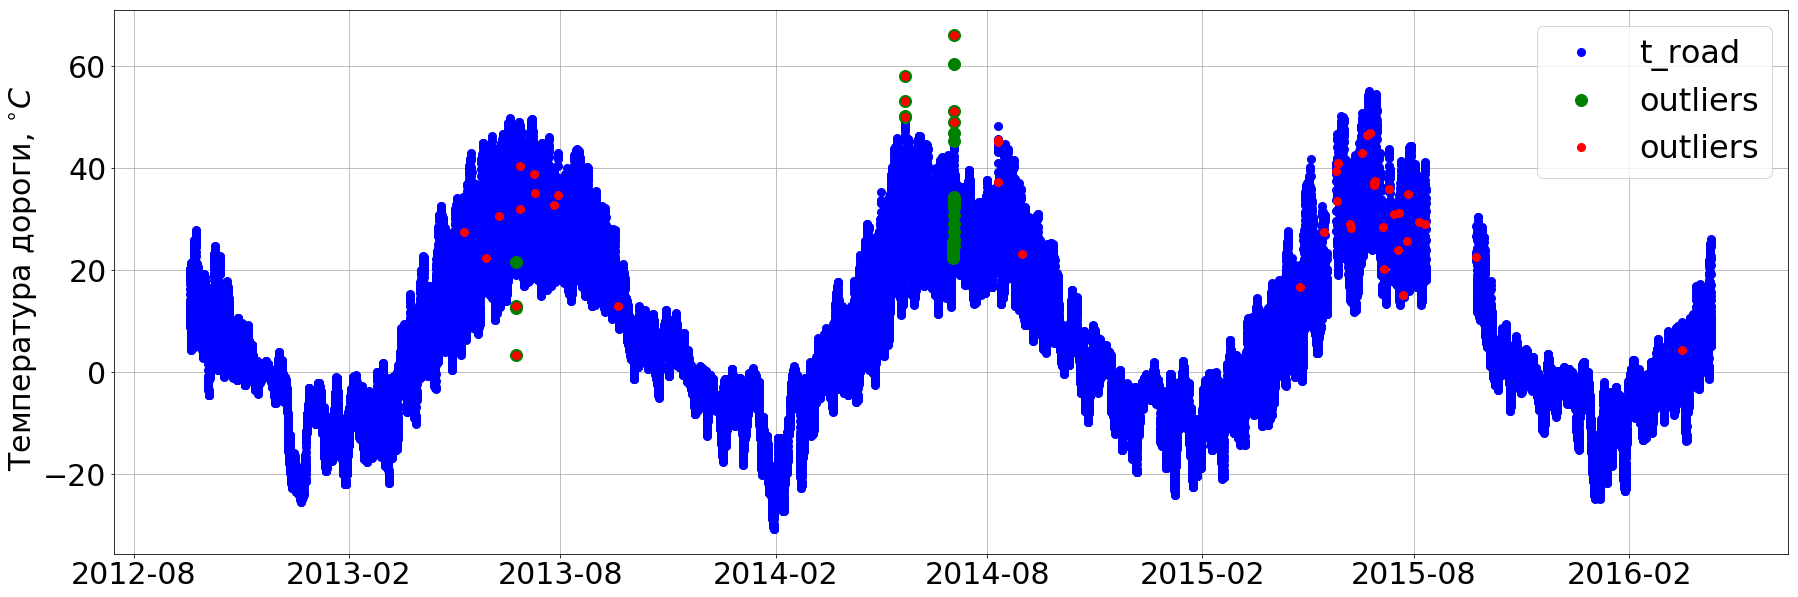

In [20]:
import matplotlib.pyplot as plt

#303, 307!!, 393!!, 503, 516
#test_station_id = [114, 117, 119, 302, 303, 307, 393, 442, 503, 504, 511, 516, 1838, 1896]
z = copy(df_test[df_test['station_id']==114].set_index('date_time_utc'))

start = pd.Timestamp(2012, 6, 1)
end = pd.Timestamp(2017, 8, 1)

to_plot = z[(z.index<=end) & (z.index>=start)]

plt.figure(figsize=(30, 10))

for elem in [True, False]:
    cond_predict = (to_plot['label_predict'] == 0) == elem
    cond_true = (to_plot['label_true'] == 0) == elem
    
    if elem:
        plt.plot_date(to_plot[cond_predict].index, to_plot[cond_predict]['target_t_road'], 'b',
                      linestyle='none', marker='o', markersize=8, label='t_road')
    else:
        
        plt.plot_date(to_plot[cond_true].index, to_plot[cond_true]['target_t_road'], 'g.',
                              linestyle='none', marker='o', label='outliers', markersize=12)
        
        plt.plot_date(to_plot[cond_predict].index, to_plot[cond_predict]['target_t_road'], 'r.',
                              linestyle='none', marker='o', label='outliers', markersize=8)

plt.grid()
plt.legend(fontsize=32)
plt.ylabel(r' Температура дороги, $^{\circ}C$', fontsize=30)

plt.tick_params(labelsize=30)
plt.show()